# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_pred import *

# Prepare Data

## Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109012 entries, 0 to 109011
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        109012 non-null  int64 
 1   Title             109012 non-null  object
 2   Product Name      109012 non-null  object
 3   Length            109012 non-null  int64 
 4   Language          109012 non-null  object
 5   Title_Processed   109012 non-null  object
 6   Title_Translated  109012 non-null  object
 7   Title_Cleaned     109012 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12113 entries, 0 to 12112
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        12113 non-null  int64 
 1   Title             12113 non-null  object
 2   Product Name      12113 non-null  object
 3   Length            1211

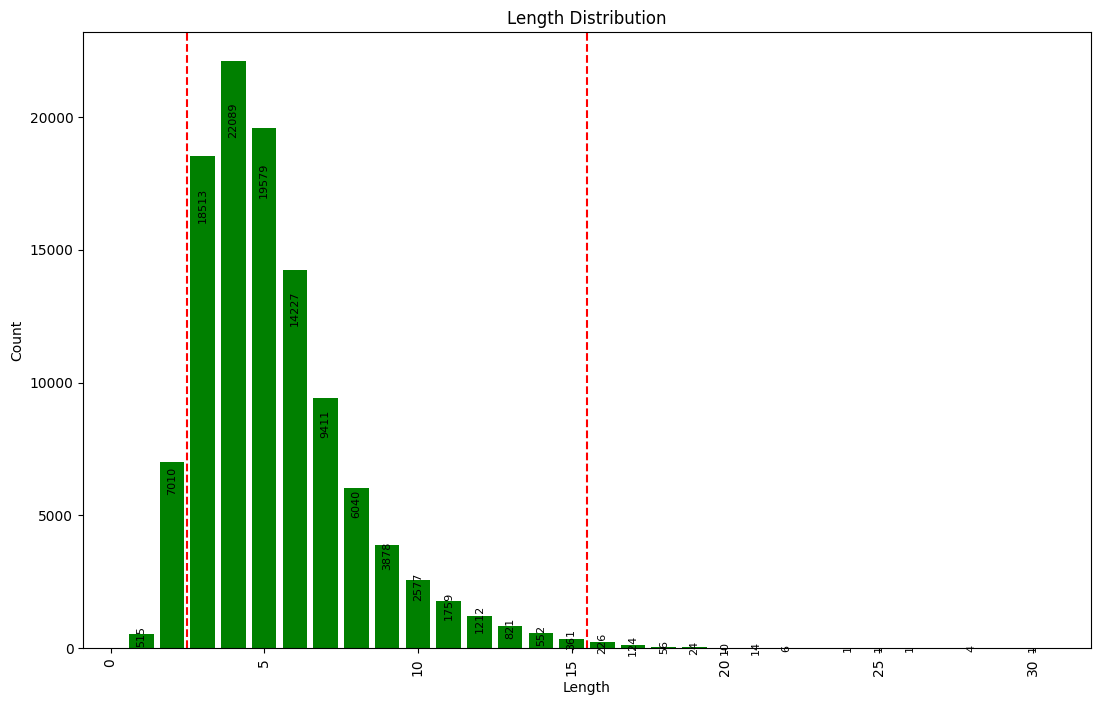

In [2]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train = pd.read_excel(excel_file_train)
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

## Remove short Titles

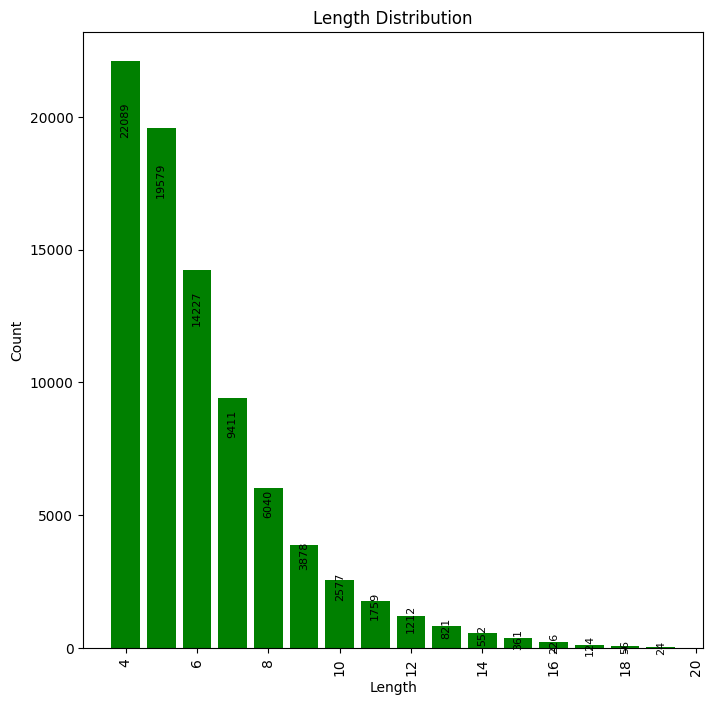

In [3]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_train['Length'] > 3) & (df_train['Length'] < 20)
df_train = df_train[mask]
hist_by_labels(df_train, 'Length', horizontal=True)

## Combine the long tail into Others

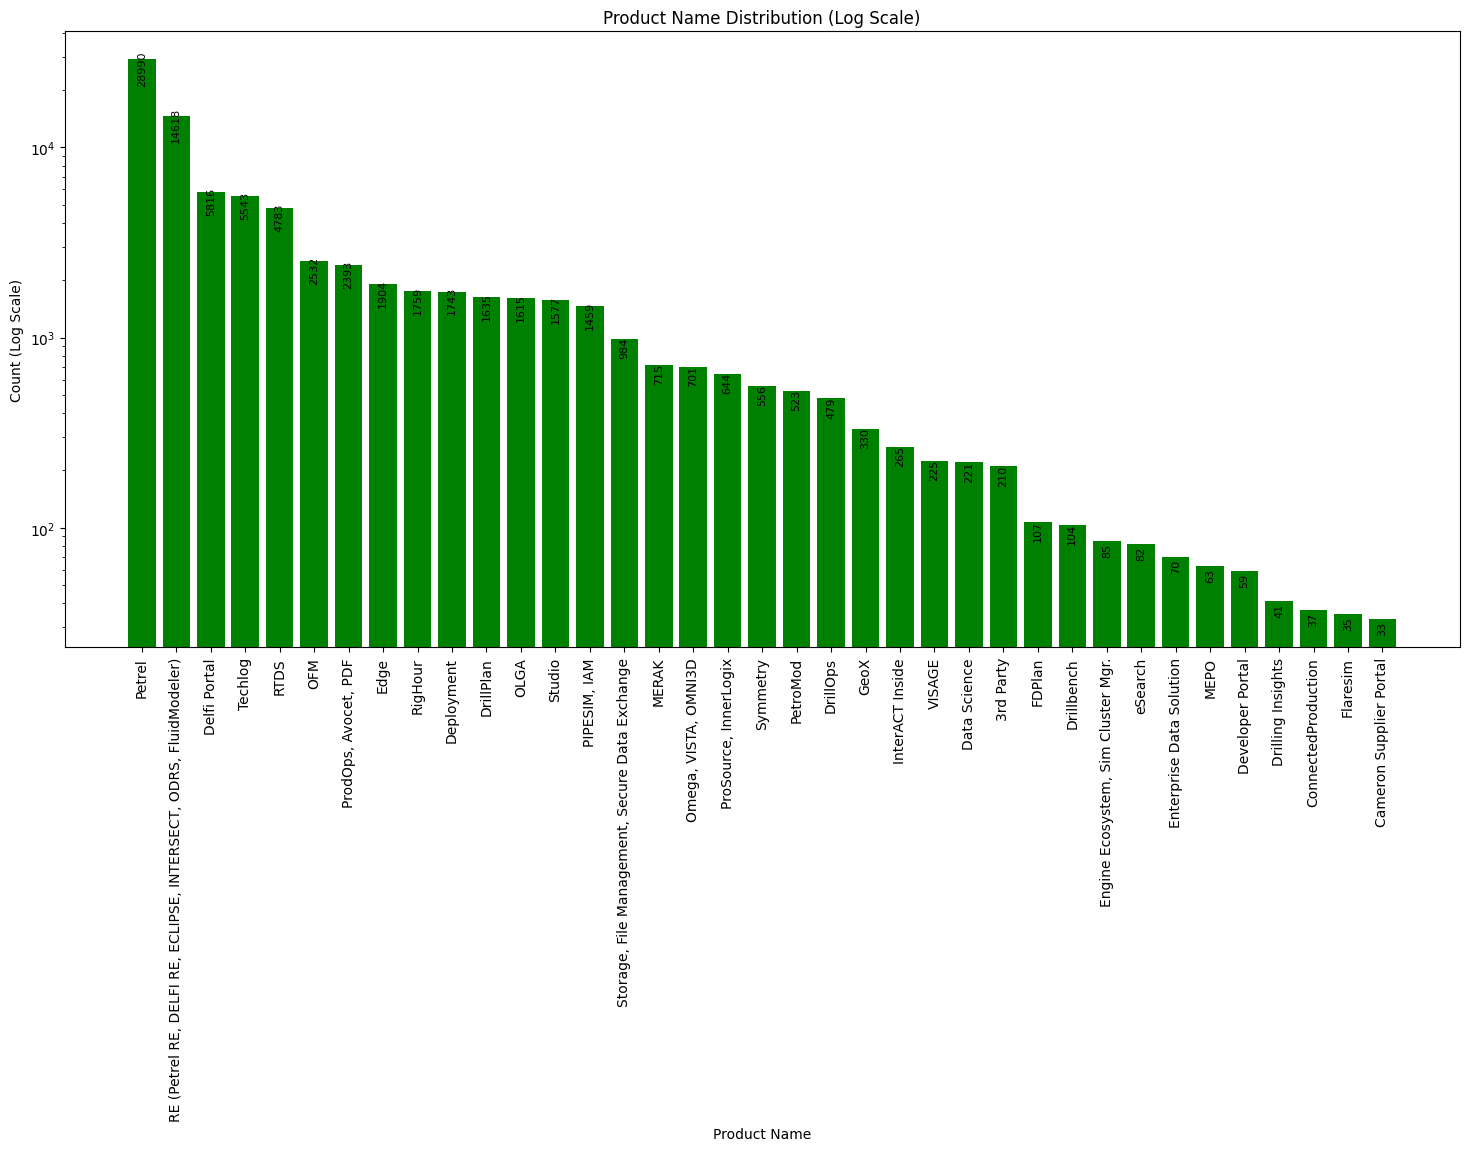

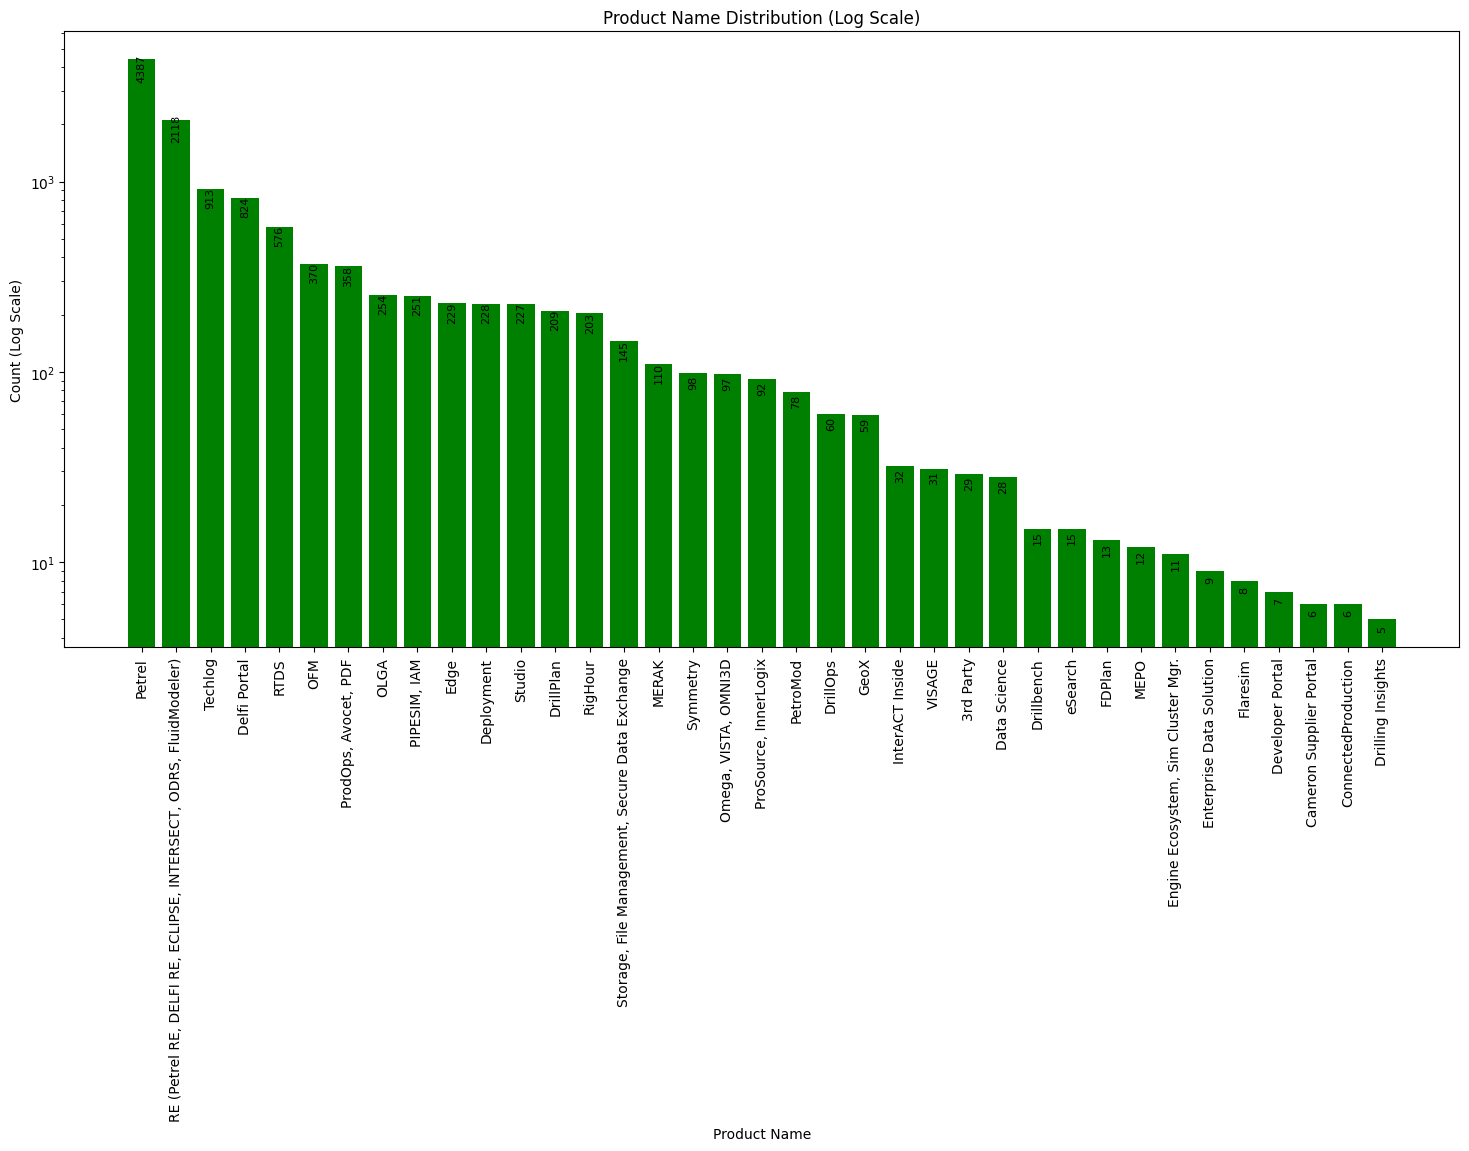

In [4]:
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_test, 'Product Name', top=None, log=True, horizontal=True)

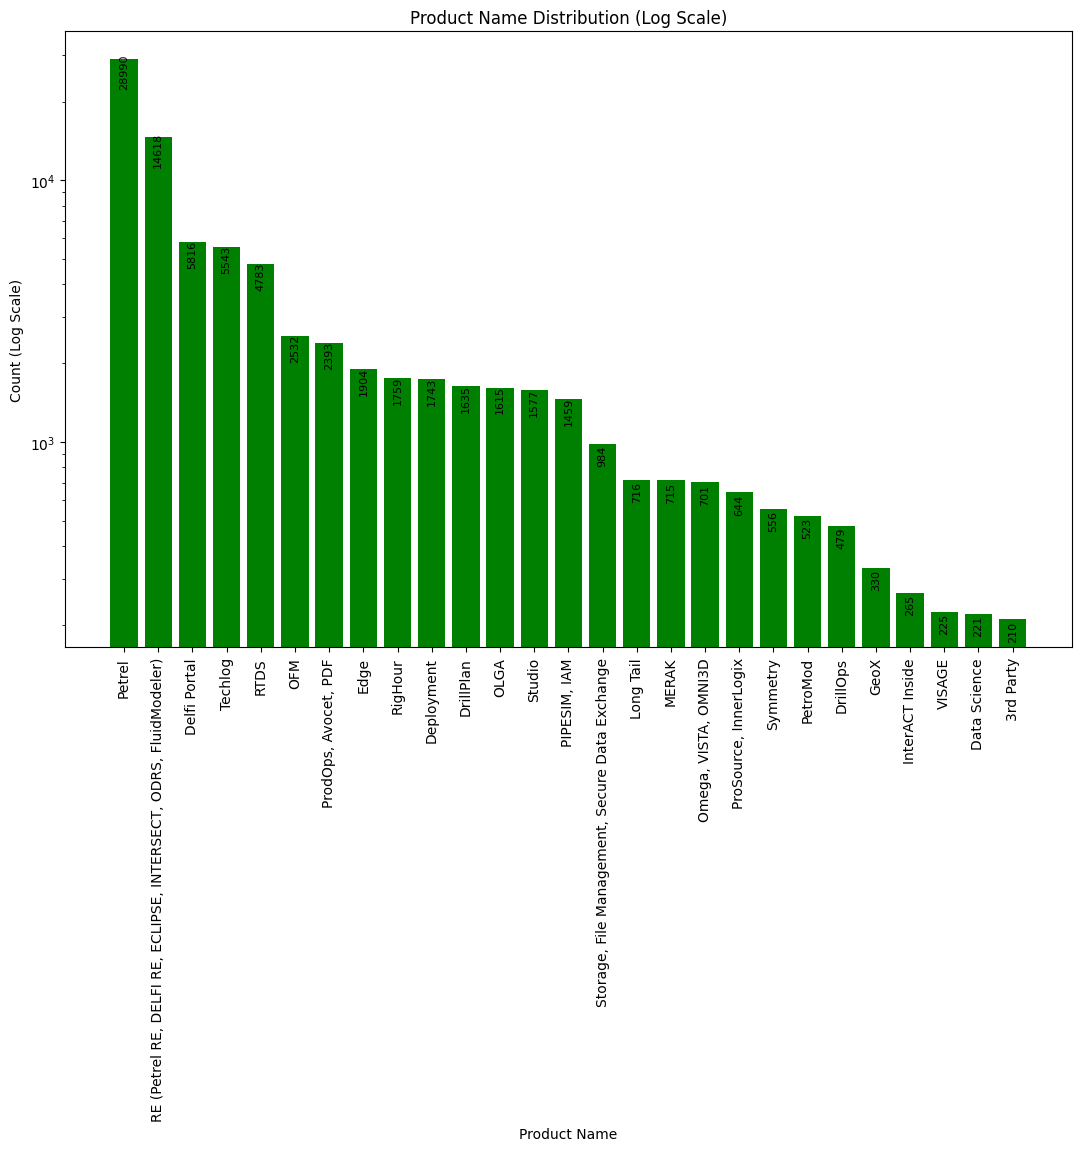

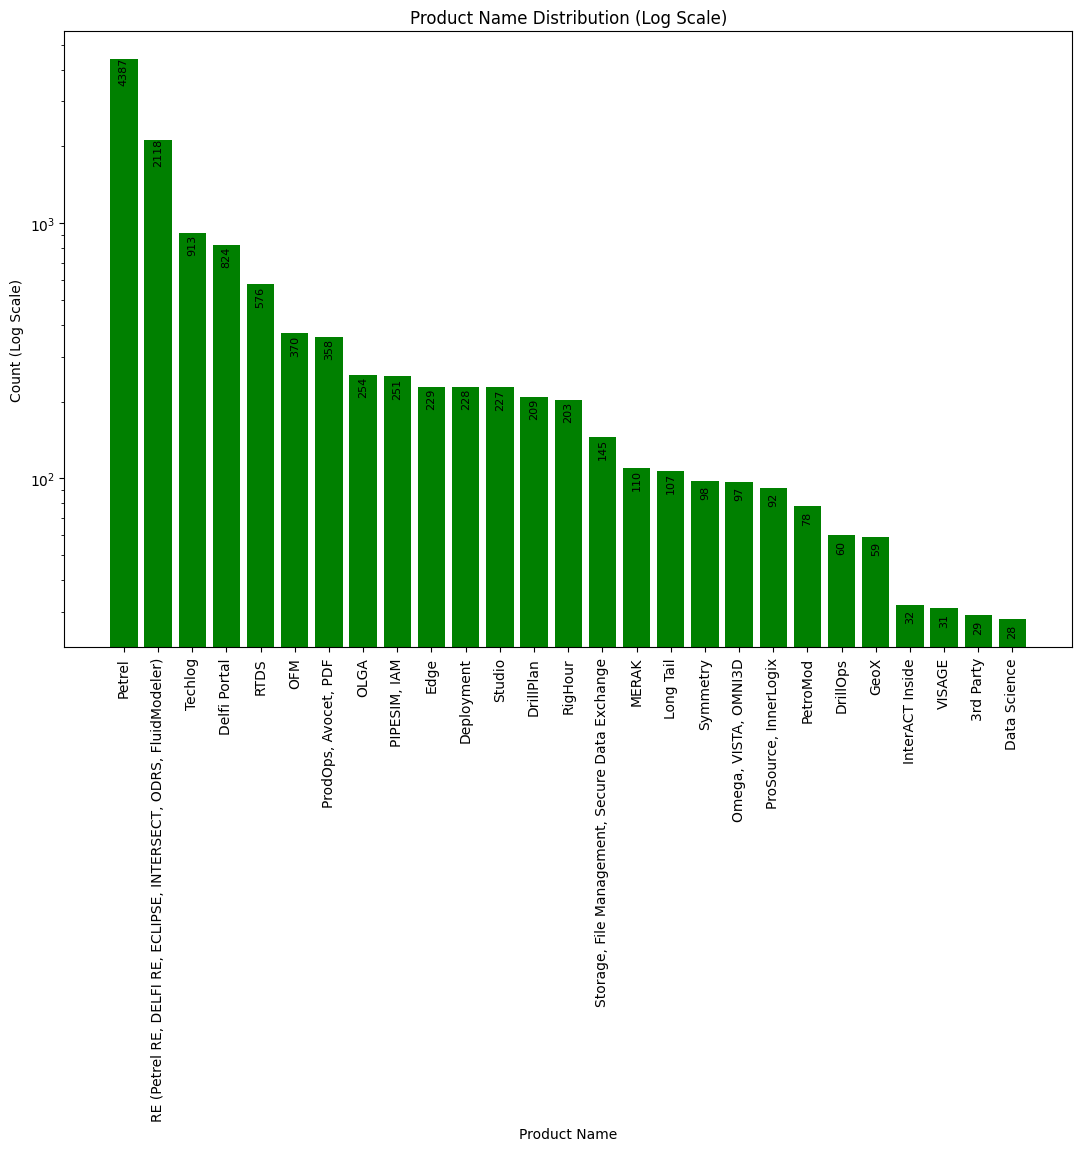

In [5]:
# Keep the top 50 products and combine the rest into 'Others'
cutoff = 200

product_counts = df_train['Product Name'].value_counts()
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_train['Product Name'].isin(product_others)
df_train.loc[mask_others,'Product Name']='Long Tail'

mask_others = df_test['Product Name'].isin(product_others)
df_test.loc[mask_others,'Product Name']='Long Tail'

hist_by_labels(df_train, 'Product Name', log=True)
hist_by_labels(df_test, 'Product Name', log=True)

## Balance Train and Test Data

<class 'pandas.core.frame.DataFrame'>
Index: 32261 entries, 85348 to 109010
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        32261 non-null  int64 
 1   Title             32261 non-null  object
 2   Product Name      32261 non-null  object
 3   Length            32261 non-null  int64 
 4   Language          32261 non-null  object
 5   Title_Processed   32261 non-null  object
 6   Title_Translated  32261 non-null  object
 7   Title_Cleaned     32261 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.2+ MB
None


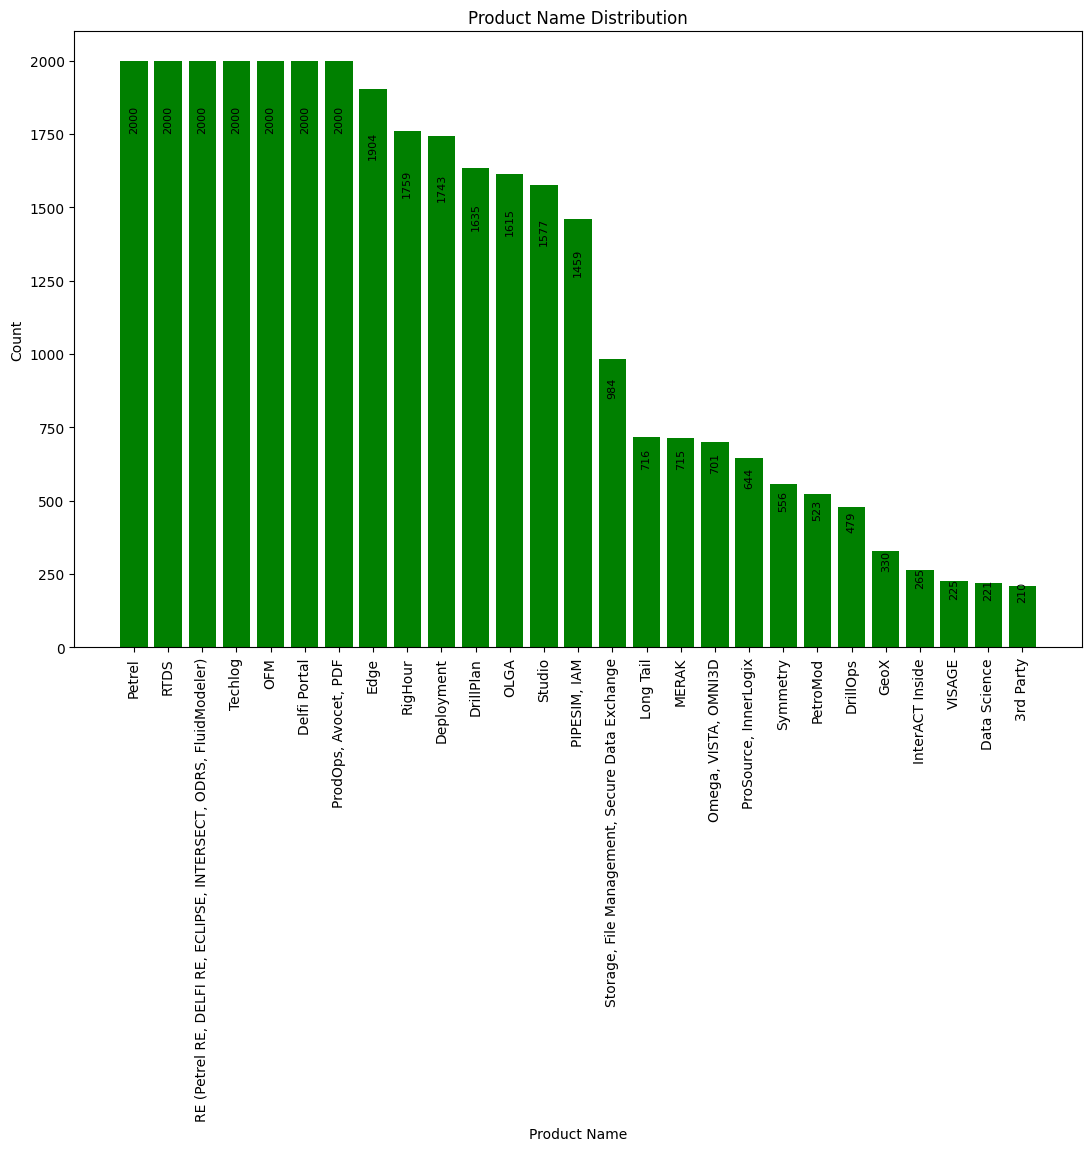

In [6]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
max_size = 2000

df_train_balanced = pd.DataFrame()

for product in df_train['Product Name'].unique():
    df_product = df_train[df_train['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_train_balanced = pd.concat([df_train_balanced, df_product_balanced])

print(df_train_balanced.info())

hist_by_labels(df_train_balanced, 'Product Name', log=False)

<class 'pandas.core.frame.DataFrame'>
Index: 4667 entries, 0 to 11640
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        4667 non-null   int64 
 1   Title             4667 non-null   object
 2   Product Name      4667 non-null   object
 3   Length            4667 non-null   int64 
 4   Language          4667 non-null   object
 5   Title_Processed   4667 non-null   object
 6   Title_Translated  4667 non-null   object
 7   Title_Cleaned     4667 non-null   object
dtypes: int64(2), object(6)
memory usage: 328.1+ KB
None


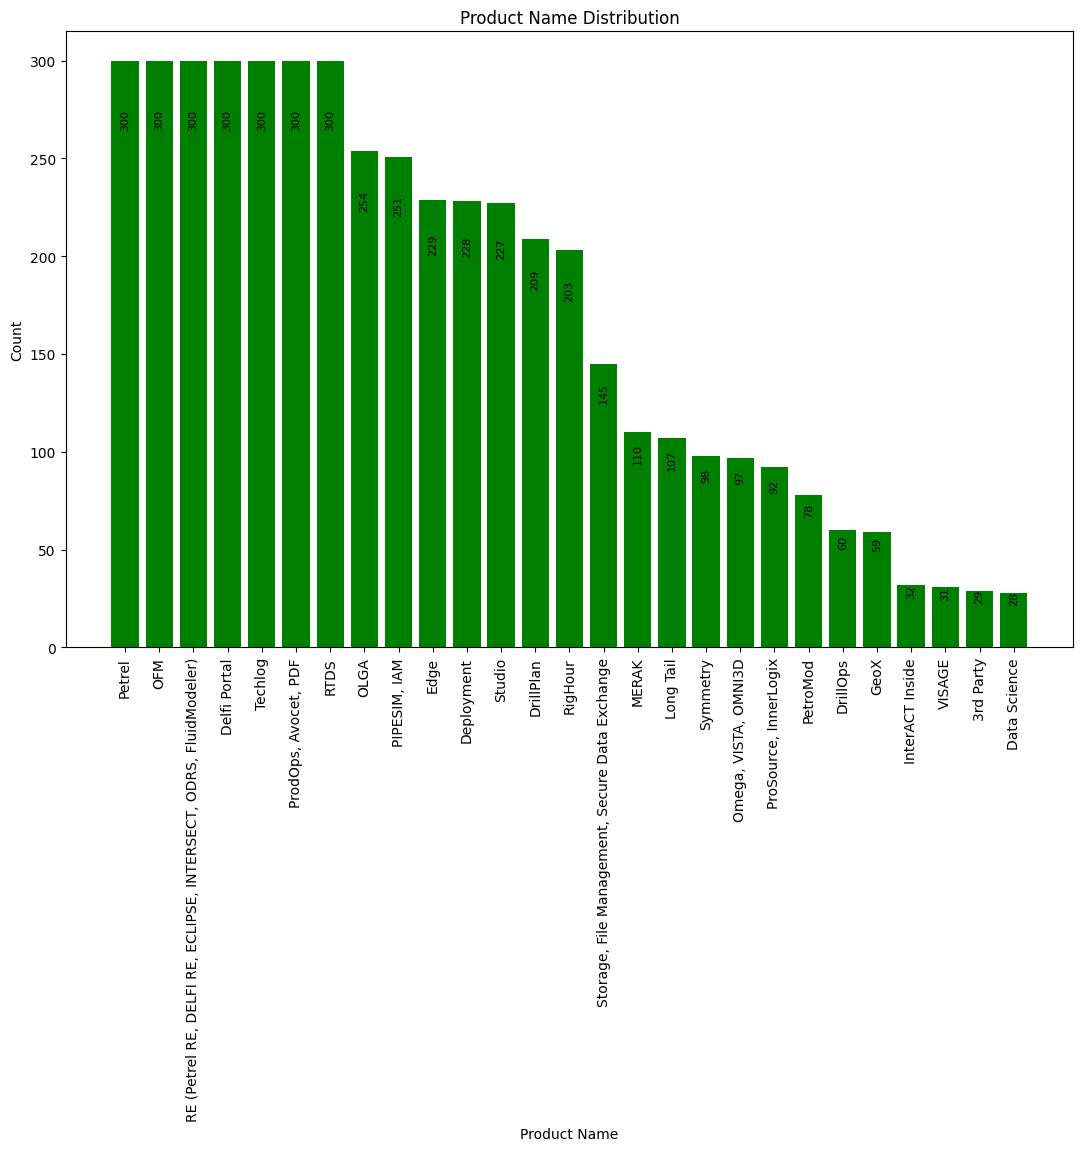

In [7]:
max_size = 300

df_test_balanced = pd.DataFrame()

for product in df_test['Product Name'].unique():
    df_product = df_test[df_test['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_test_balanced = pd.concat([df_test_balanced, df_product_balanced])

print(df_test_balanced.info())


hist_by_labels(df_test_balanced, 'Product Name', log=False)

In [8]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

column_name = 'Title_Translated'

X = df_train[column_name]

vectorizer_countvec = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_countvec.fit(X)

vectorizer_tfidf = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf.fit(X)

X_train = df_train_balanced[column_name]
y_train = df_train_balanced['Product Name']

X_test = df_test_balanced[column_name]
y_test = df_test_balanced['Product Name']

X_train_countvec = vectorizer_countvec.transform(X_train)
X_test_countvec = vectorizer_countvec.transform(X_test)

X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# vectorizer = vectorizer_countvec
# X_train_encoded = X_train_countvec
# X_test_encoded = X_test_countvec

# vectorizer = vectorizer_tfidf
# X_train_encoded = X_train_tfidf
# X_test_encoded = X_test_tfidf

# Model Baseline - Cross Validation

In [9]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
import optuna.visualization as vis
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pickle

In [10]:
models = {
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'SVC linear': SVC(kernel='linear'),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(),
    # 'SVC rbf': SVC(kernel='rbf'),
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        # X_train_countvec,
        X_train_tfidf,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.8227 by SGDClassifier.
Average score: 0.8179 by SVC linear.
Average score: 0.8048 by LogisticRegression.


In [ ]:
# Baseline Score(s) of each model are .... on augmented train dataset
# Average score: 0.8539 by SGDClassifier.
# Average score: 0.8556 by LogisticRegression.
# Average score: 0.8856 by SVC linear.
# Average score: 0.7962 by MultinomialNB.
# Average score: 0.7978 by GradientBoostingClassifier.
# Average score: 0.8716 by RandomForestClassifier.

# Hpyerparameter Tuning

## SGC Classifier

In [39]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

In [ ]:
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [40]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

[I 2023-10-22 22:15:39,788] Using an existing study with name 'sgd_classifier' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-22 22:15:43,011] Trial 313 finished with value: 0.8297944774793444 and parameters: {'alpha': 0.00014002075125623266, 'eta0': 0.07726264549433977, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 269 with value: 0.8315922687285594.
[I 2023-10-22 22:15:43,129] Trial 314 finished with value: 0.8261368218418286 and parameters: {'alpha': 0.0002602462114695278, 'eta0': 0.07500997493923363, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 269 with value: 0.8315922687285594.
[I 2023-10-22 22:15:43,156] Trial 311 finished with value: 0.8297944774793444 and parameters: {'alpha': 0.00014076775627493103, 'eta0': 0.07426245391970866, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 269 with value: 0.8315922687285594.
[I 2023-10-22 22:15:43,178] Trial 315 finished with value: 0.8302284370298698 and parameters: {'alpha': 0.00013517519605992775, 'eta0': 0.07519780247189263, 'loss':

In [41]:
vis.plot_optimization_history(study)

In [42]:
vis.plot_slice(study)

Accuracy: 0.799443
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.545     0.207     0.300        29
                                                    Data Science      0.909     0.714     0.800        28
                                                    Delfi Portal      0.635     0.720     0.675       300
                                                      Deployment      0.771     0.711     0.740       228
                                                        DrillOps      0.860     0.717     0.782        60
                                                       DrillPlan      0.741     0.876     0.803       209
                                                            Edge      0.974     0.978     0.976       229
                                                            GeoX      0.980     0.847     0.909        59
                          

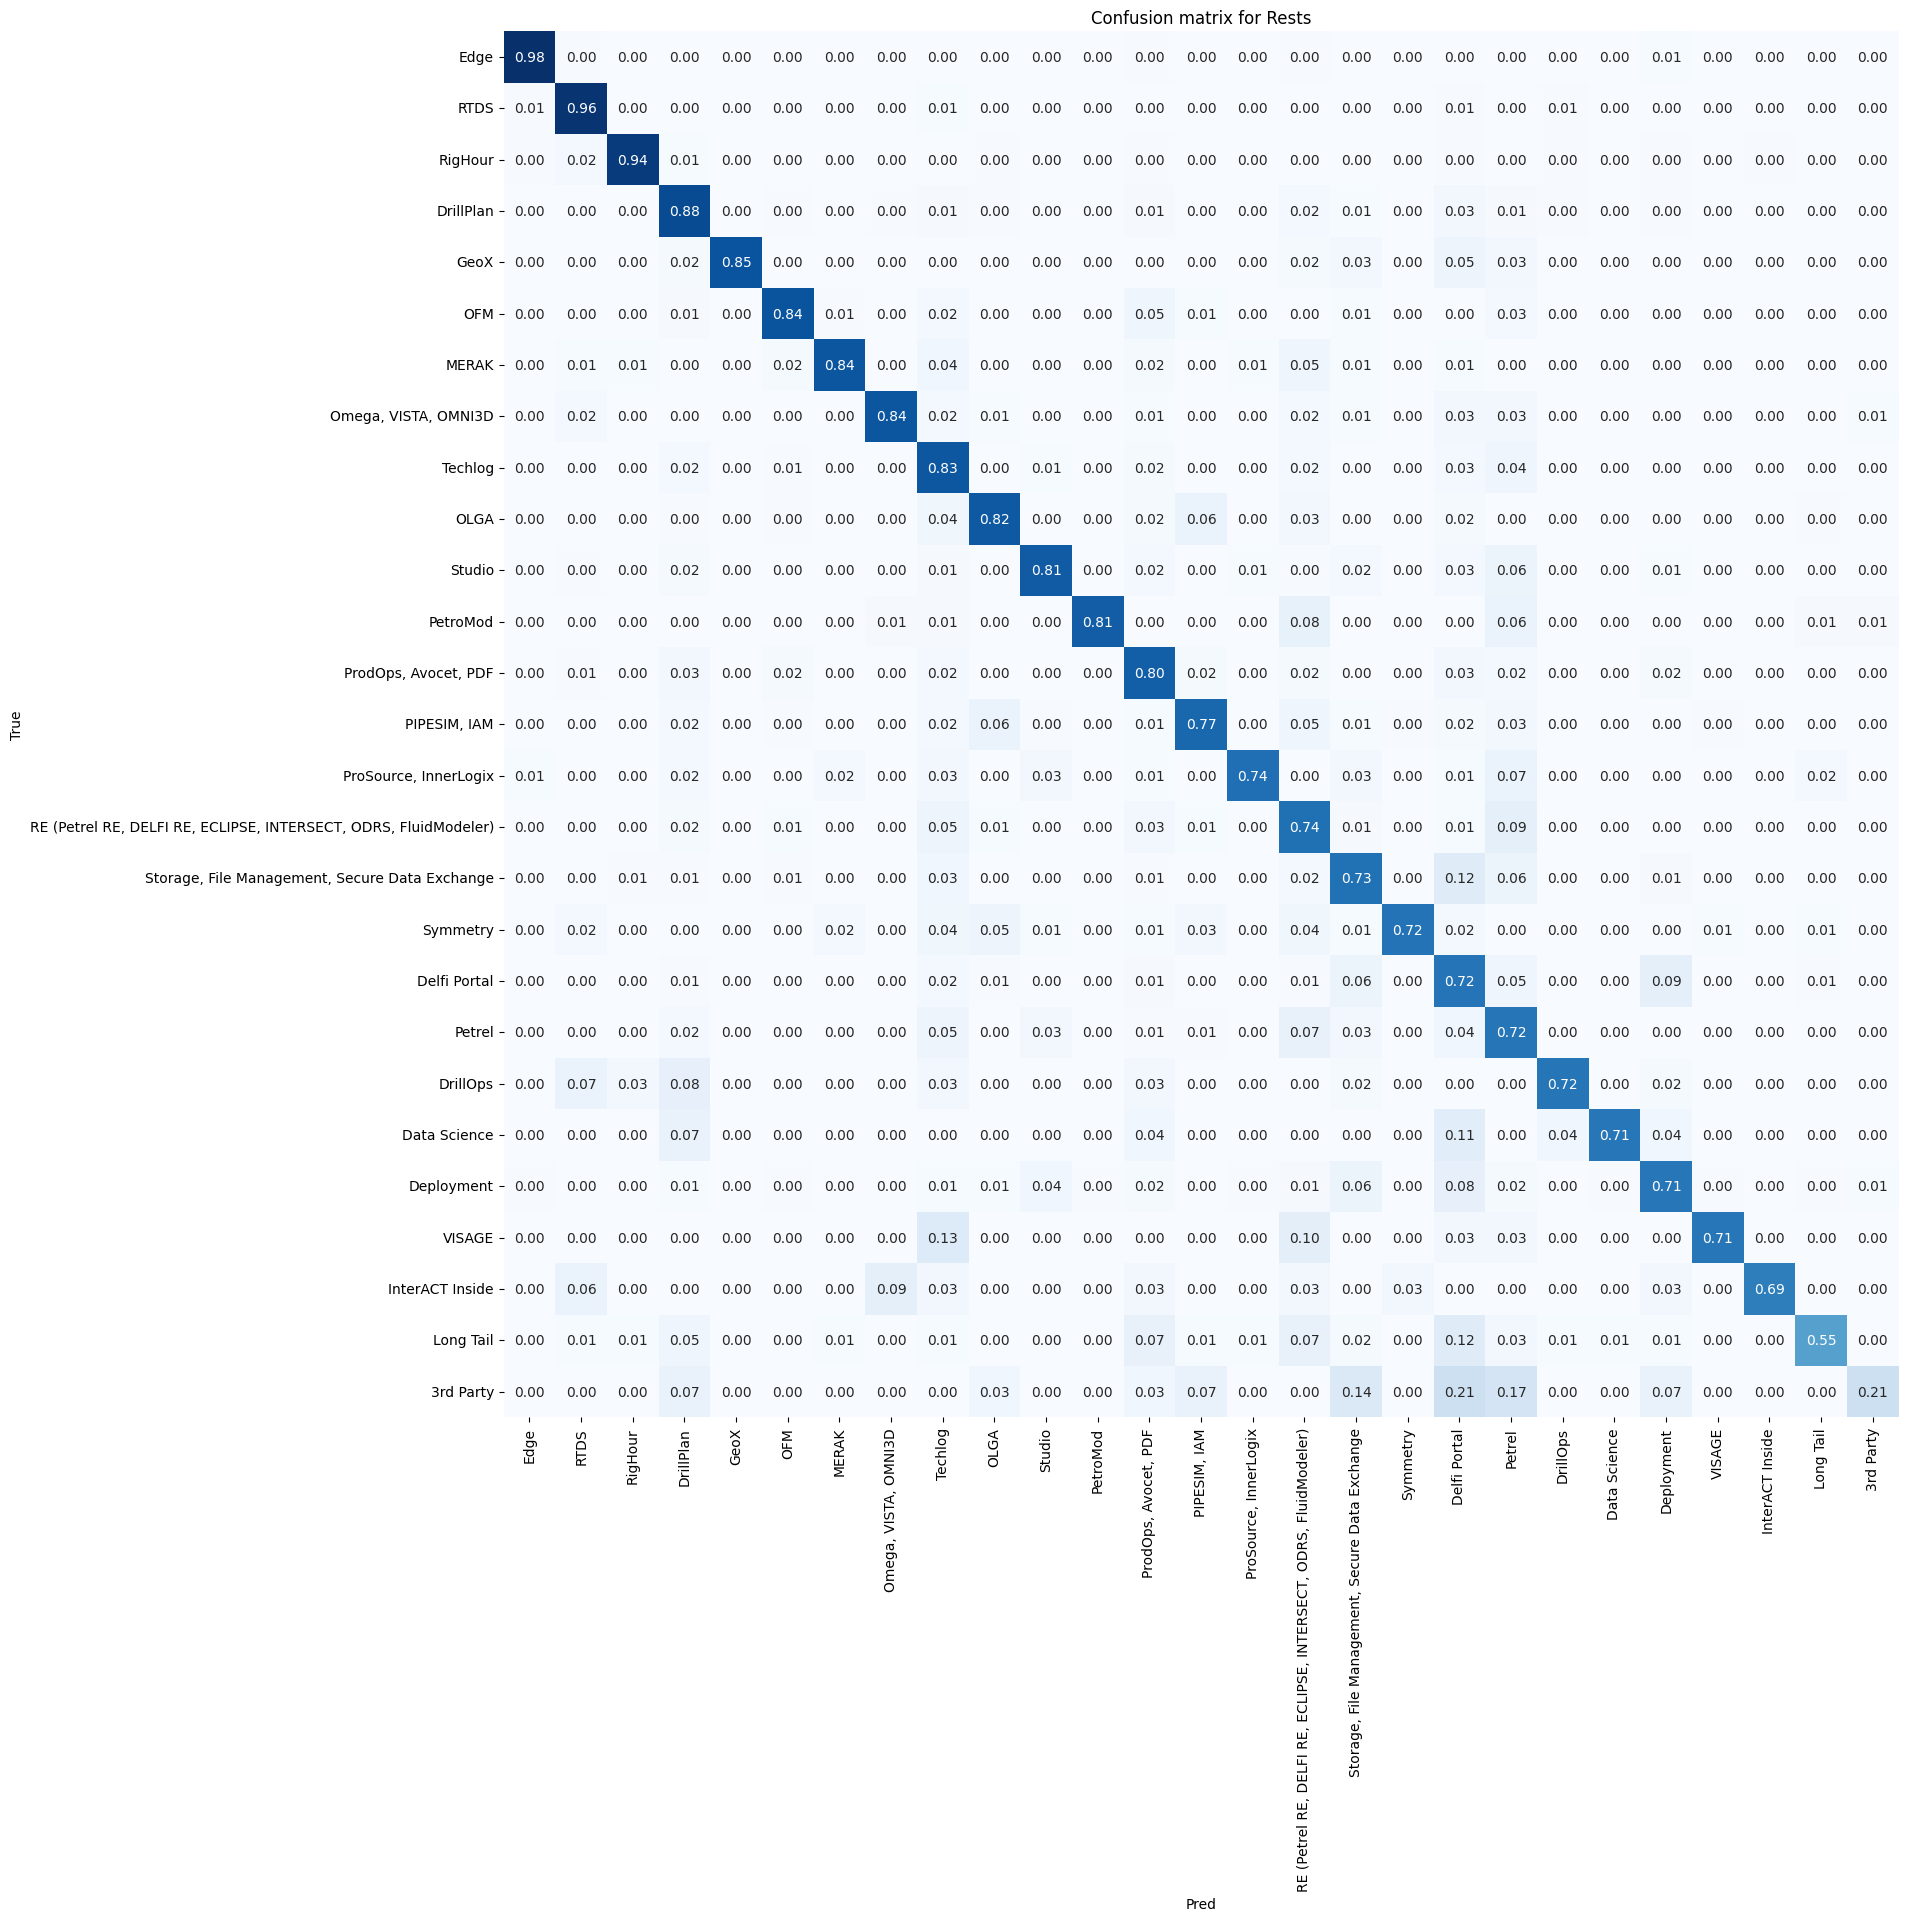

Accuracy of top 1 prediction is 0.799.
Accuracy of top 3 prediction is 0.904.
Accuracy of top 5 prediction is 0.935.


In [43]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_tfidf, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [44]:
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

## Logistic Classification

In [11]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

/var/folders/r4/9ch2b93x7yd208vwqjxkx9180000gn/T/ipykernel_55095/1496174548.py:5: FutureWarning: delete_study(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.
  optuna.delete_study(study_name, storage=storage_name)


In [22]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-2, 1e+4, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 10000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=50, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-22 17:55:33,796] Using an existing study with name 'logReg' instead of creating a new one.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-22 17:56:42,719] Trial 39 finished with value: 0.8238430219213967 and parameters: {'solver': 'saga', 'C': 3.763434070615141}. Best is trial 39 with value: 0.8238430219213967.
[I 2023-10-22 17:56:46,485] Trial 33 finished with value: 0.823750027501062 and parameters: {'solver': 'saga', 'C': 4.327368060889205}. Best is trial 39 with value: 0.8238430219213967.
[I 2023-10-22 17:56:51,511] Trial 32 finished with value: 0.824214985191699 and parameters: {'solver': 'saga', 'C': 5.260052278739662}. Best is trial 32 with value: 0.824214985191699.
[I 2023-10-22 17:56:53,557] Trial 36 finished with value: 0.8240600040984989 and parameters: {'solver': 'saga', 'C': 5.411802076854689}. Best is trial 32 with value: 0.824214985191699.
[I 2023-10-22 17:56:57,385] Trial 38 finished with value: 0.8241529745004389 and parameters: {'solver': 'saga', 'C': 6.360798983361549}. Best is trial 32 with value: 0.824214985191699.
[I 2023-10-22 17:56:58,178] Trial 34 finished with value: 0.824276952649848

In [23]:
vis.plot_optimization_history(study)

In [24]:
vis.plot_slice(study)

Accuracy: 0.7947
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.533     0.276     0.364        29
                                                    Data Science      0.857     0.643     0.735        28
                                                    Delfi Portal      0.606     0.703     0.651       300
                                                      Deployment      0.716     0.706     0.711       228
                                                        DrillOps      0.909     0.667     0.769        60
                                                       DrillPlan      0.743     0.856     0.796       209
                                                            Edge      0.982     0.978     0.980       229
                                                            GeoX      0.940     0.797     0.862        59
                            

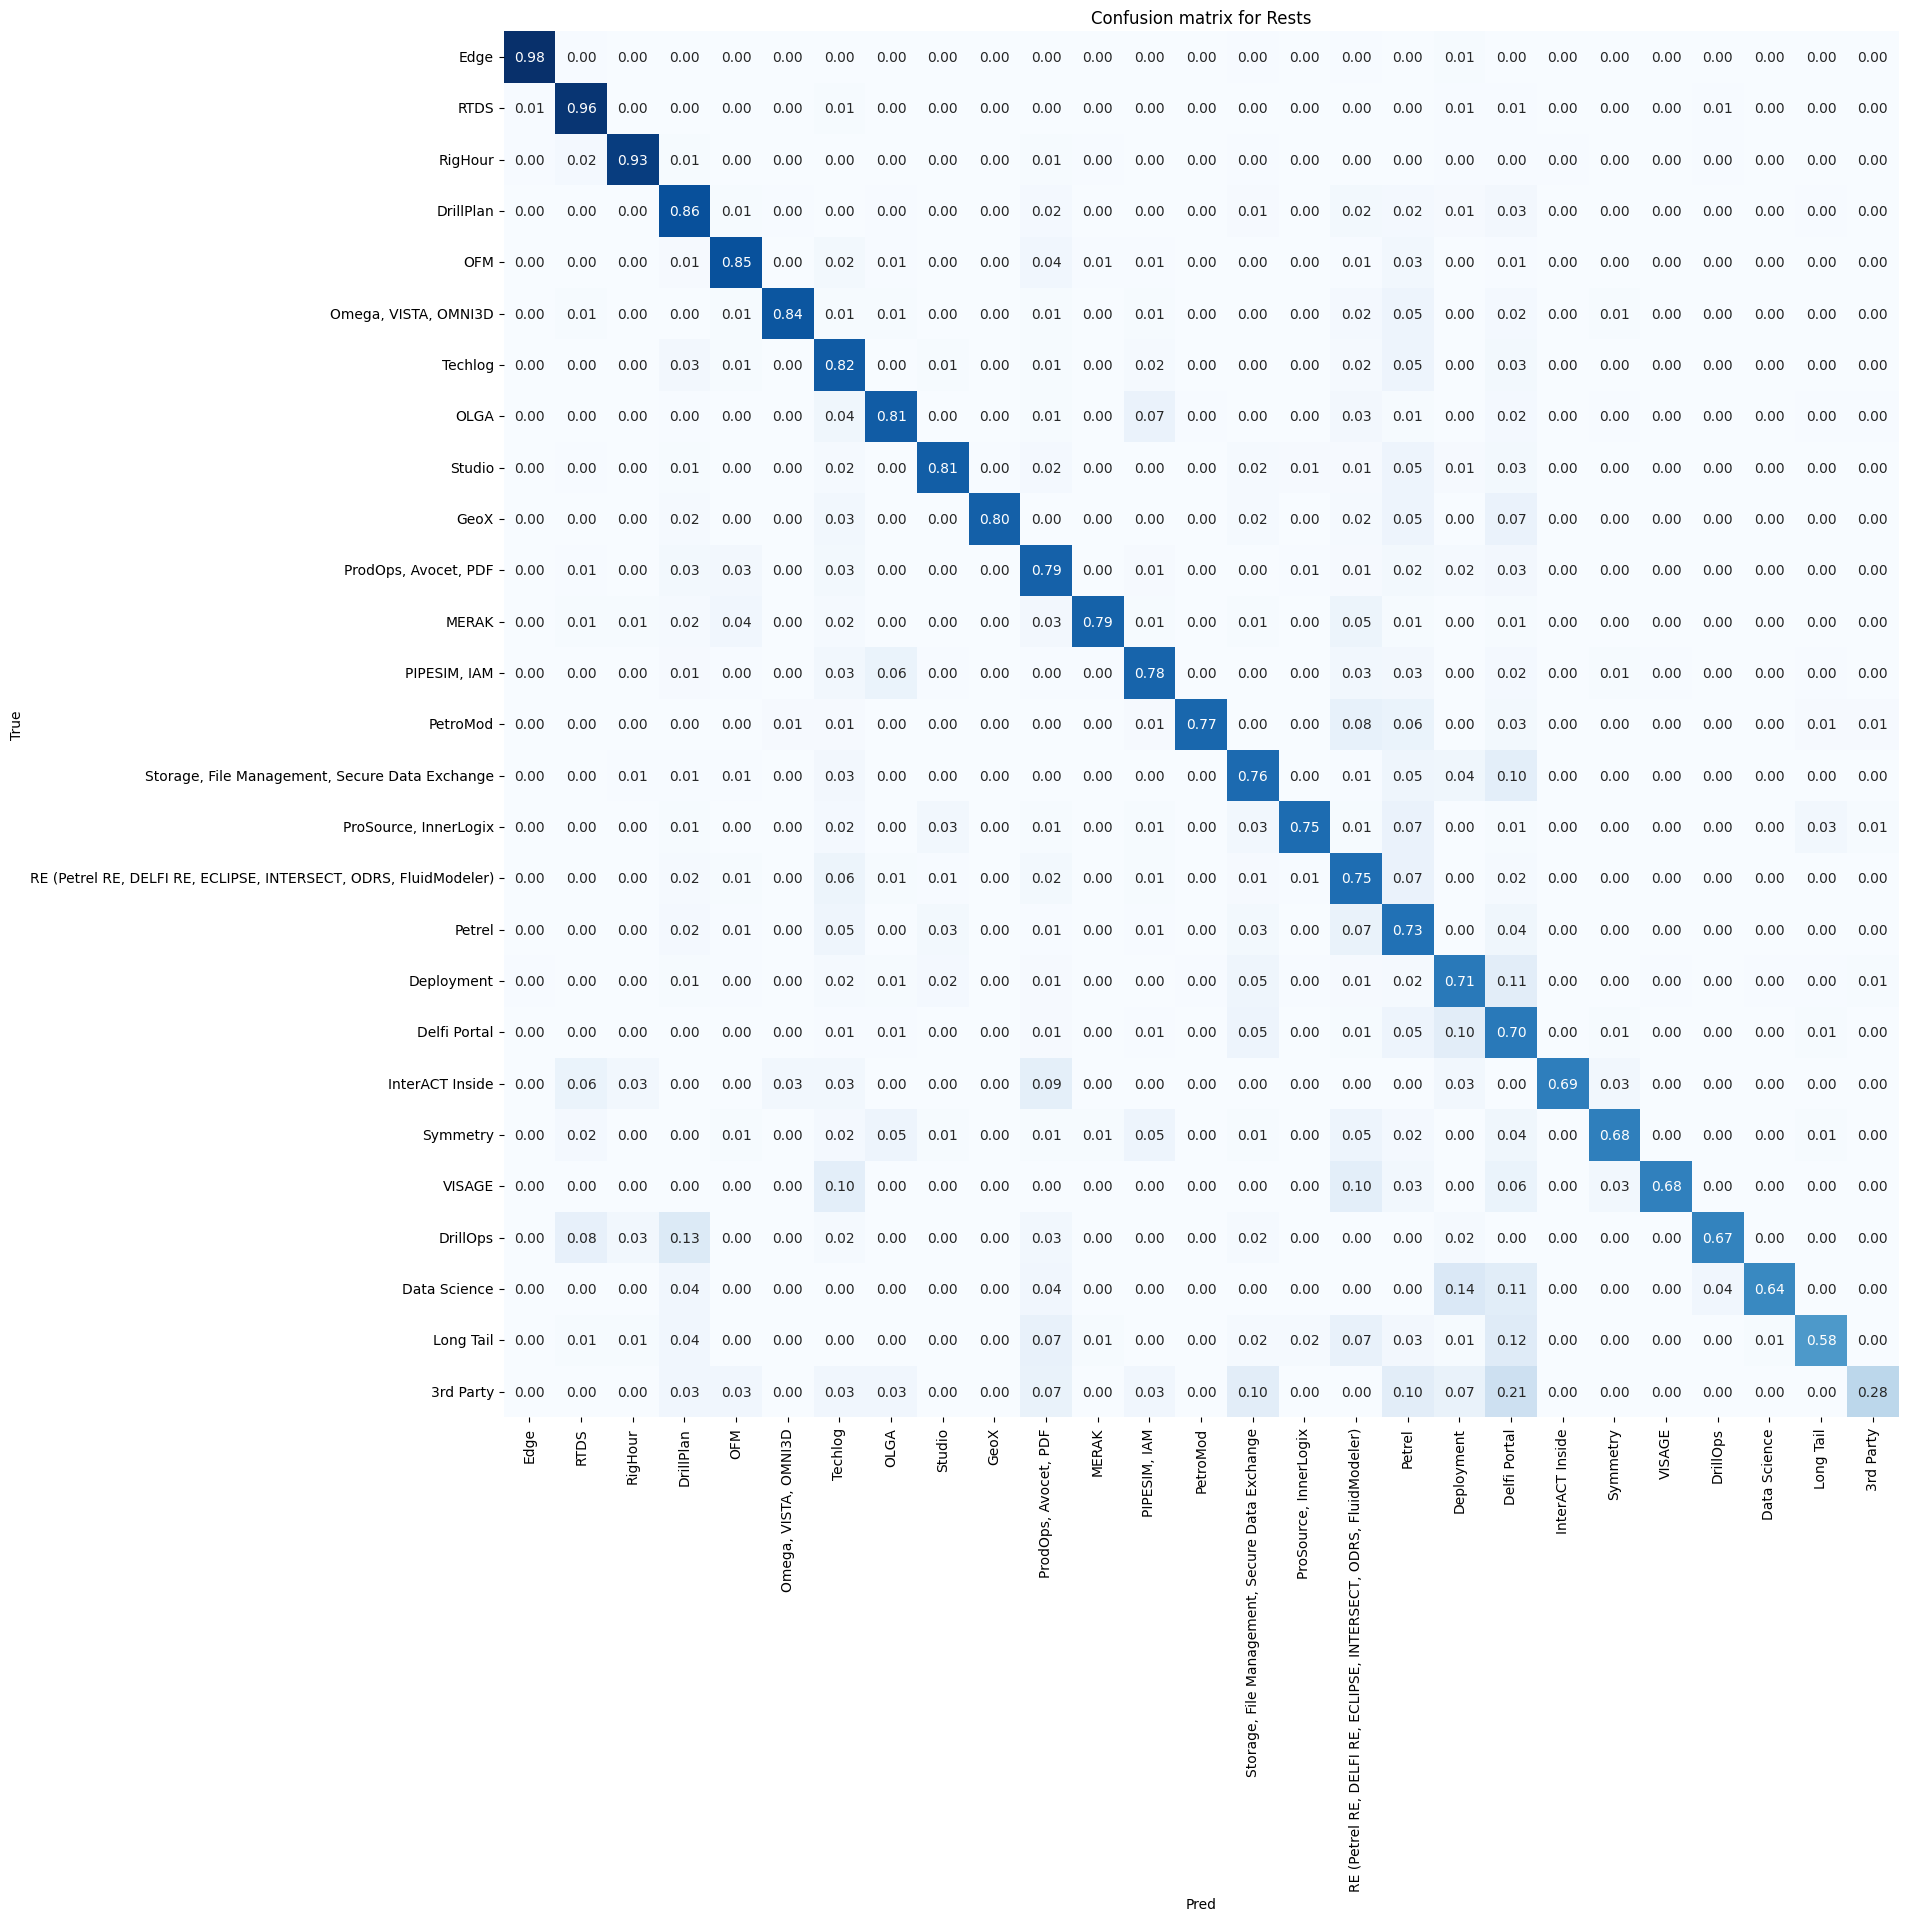

Accuracy of top 1 prediction is 0.795.
Accuracy of top 3 prediction is 0.906.
Accuracy of top 5 prediction is 0.940.


In [25]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Create and train the best Logistic Regression model
model_logReg= LogisticRegression(max_iter=5000)
model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer_countvec, X_test, y_test, pre_processed=True)

In [26]:
# export the model
import pickle
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_countvec, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_countvec, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear

In [27]:
# Clean up the study if it exists
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

/var/folders/r4/9ch2b93x7yd208vwqjxkx9180000gn/T/ipykernel_55095/3196997116.py:5: FutureWarning:

delete_study(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.



In [34]:
# user Optuna to tune the hyperparameters for SVC Linear

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_tfidf, y_train)

[I 2023-10-22 21:37:58,304] Using an existing study with name 'SVC_linear' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-10-22 21:56:52,933] Trial 17 finished with value: 0.8150397807062927 and parameters: {'C': 0.8542598932085348}. Best is trial 4 with value: 0.8174886289714296.
[I 2023-10-22 21:57:11,164] Trial 15 finished with value: 0.8115991264605945 and parameters: {'C': 0.6816050839936445}. Best is trial 4 with value: 0.8174886289714296.
[I 2023-10-22 21:57:53,180] Trial 14 finished with value: 0.8199683696957418 and parameters: {'C': 1.325368496151228}. Best is trial 14 with value: 0.8199683696957418.
[I 2023-10-22 21:57:53,807] Trial 13 finished with value: 0.8191624276601981 and parameters: {'C': 1.8558771188095695}. Best is trial 14 with value: 0.8199683696957418.
[I 2023-10-22 21:57:54,002] Trial 10 finished with value: 0.8201853374618071 and parameters: {'C': 1.4256028473822318}. Best is trial 10 with value: 0.8201853374618071.
[I 2023-10-22 21:58:03,544] Trial 11 finished with value: 0.8190694284361845 and parameters: {'C': 1.079318682948503}. Best is trial 10 with value: 0.82018533

SVC(C=1.4256028473822318, kernel='linear')

In [35]:
vis.plot_optimization_history(study)

In [36]:
vis.plot_slice(study)

Accuracy: 0.794300
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.438     0.241     0.311        29
                                                    Data Science      0.783     0.643     0.706        28
                                                    Delfi Portal      0.607     0.747     0.670       300
                                                      Deployment      0.752     0.732     0.742       228
                                                        DrillOps      0.918     0.750     0.826        60
                                                       DrillPlan      0.737     0.856     0.792       209
                                                            Edge      0.987     0.974     0.980       229
                                                            GeoX      0.980     0.814     0.889        59
                          

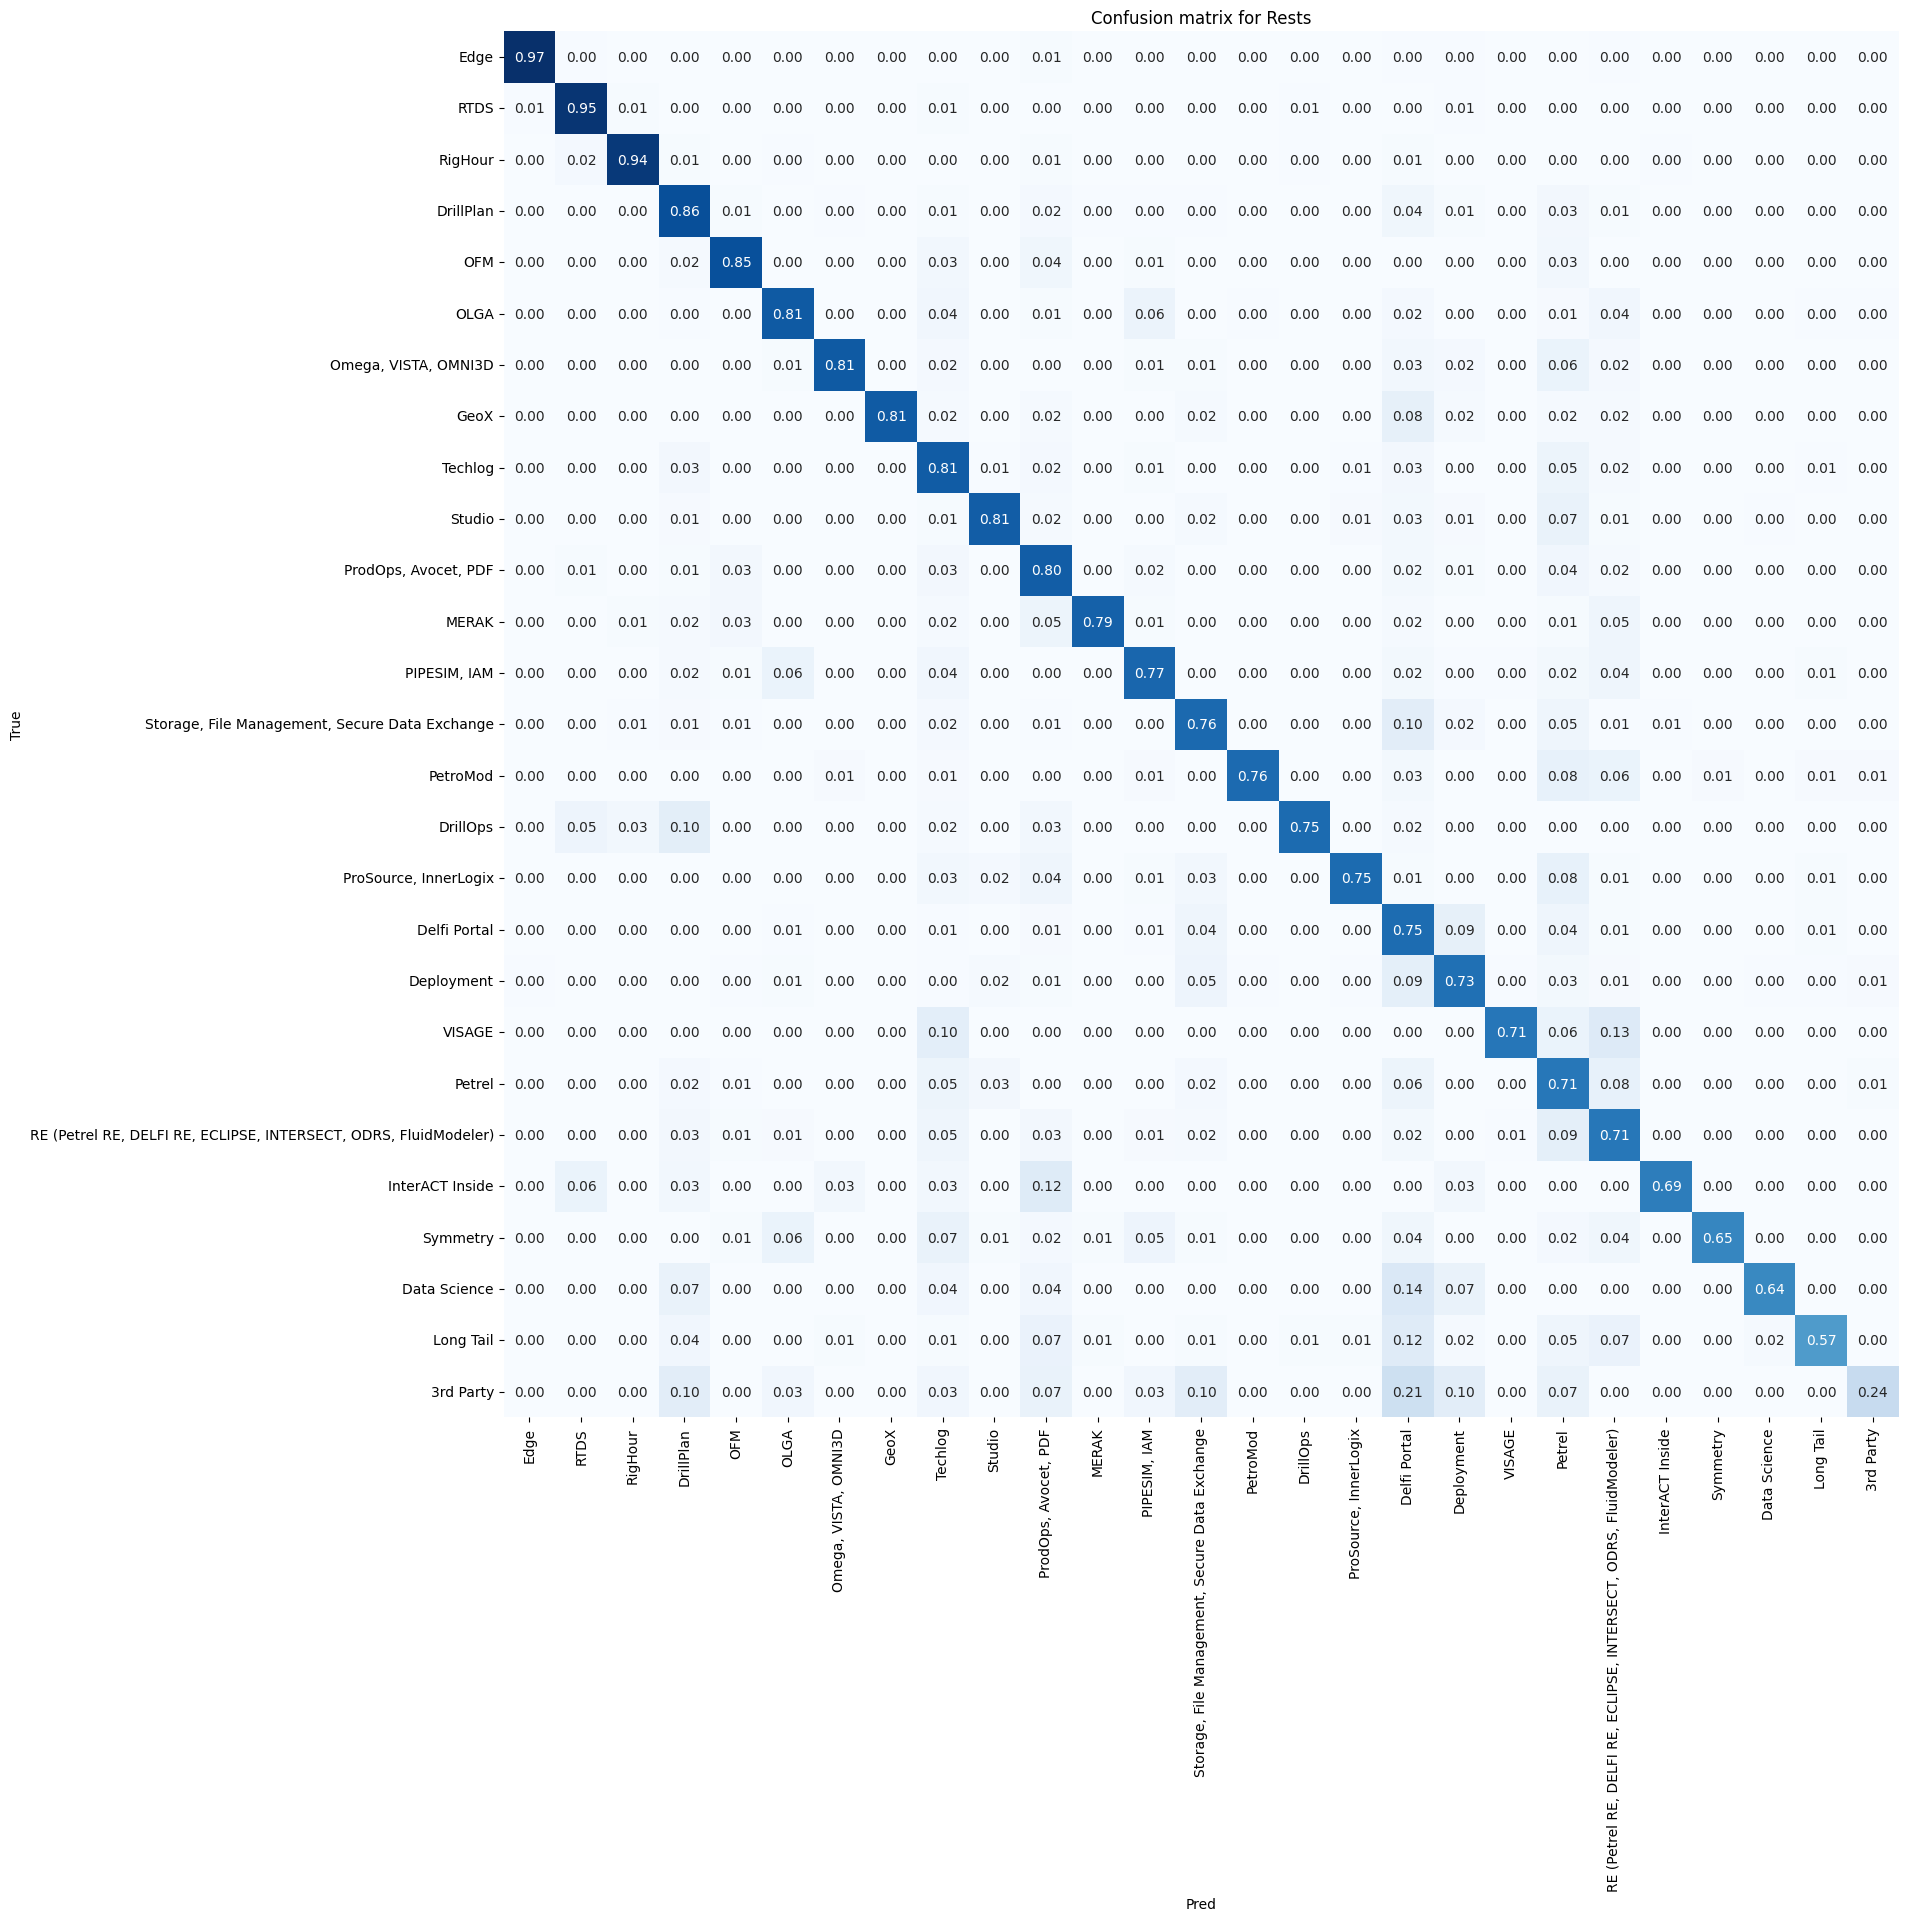

Accuracy of top 1 prediction is 0.792.
Accuracy of top 3 prediction is 0.909.
Accuracy of top 5 prediction is 0.942.


In [37]:
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
# best_model_svc_linear = SVC(kernel='linear', probability=True)
best_model_svc_linear.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [38]:
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

Accuracy: 0.7984
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.625     0.345     0.444        29
                                                    Data Science      0.792     0.679     0.731        28
                                                    Delfi Portal      0.624     0.707     0.662       300
                                                      Deployment      0.755     0.715     0.734       228
                                                        DrillOps      0.846     0.733     0.786        60
                                                       DrillPlan      0.761     0.852     0.804       209
                                                            Edge      0.978     0.978     0.978       229
                                                            GeoX      0.960     0.814     0.881        59
                            

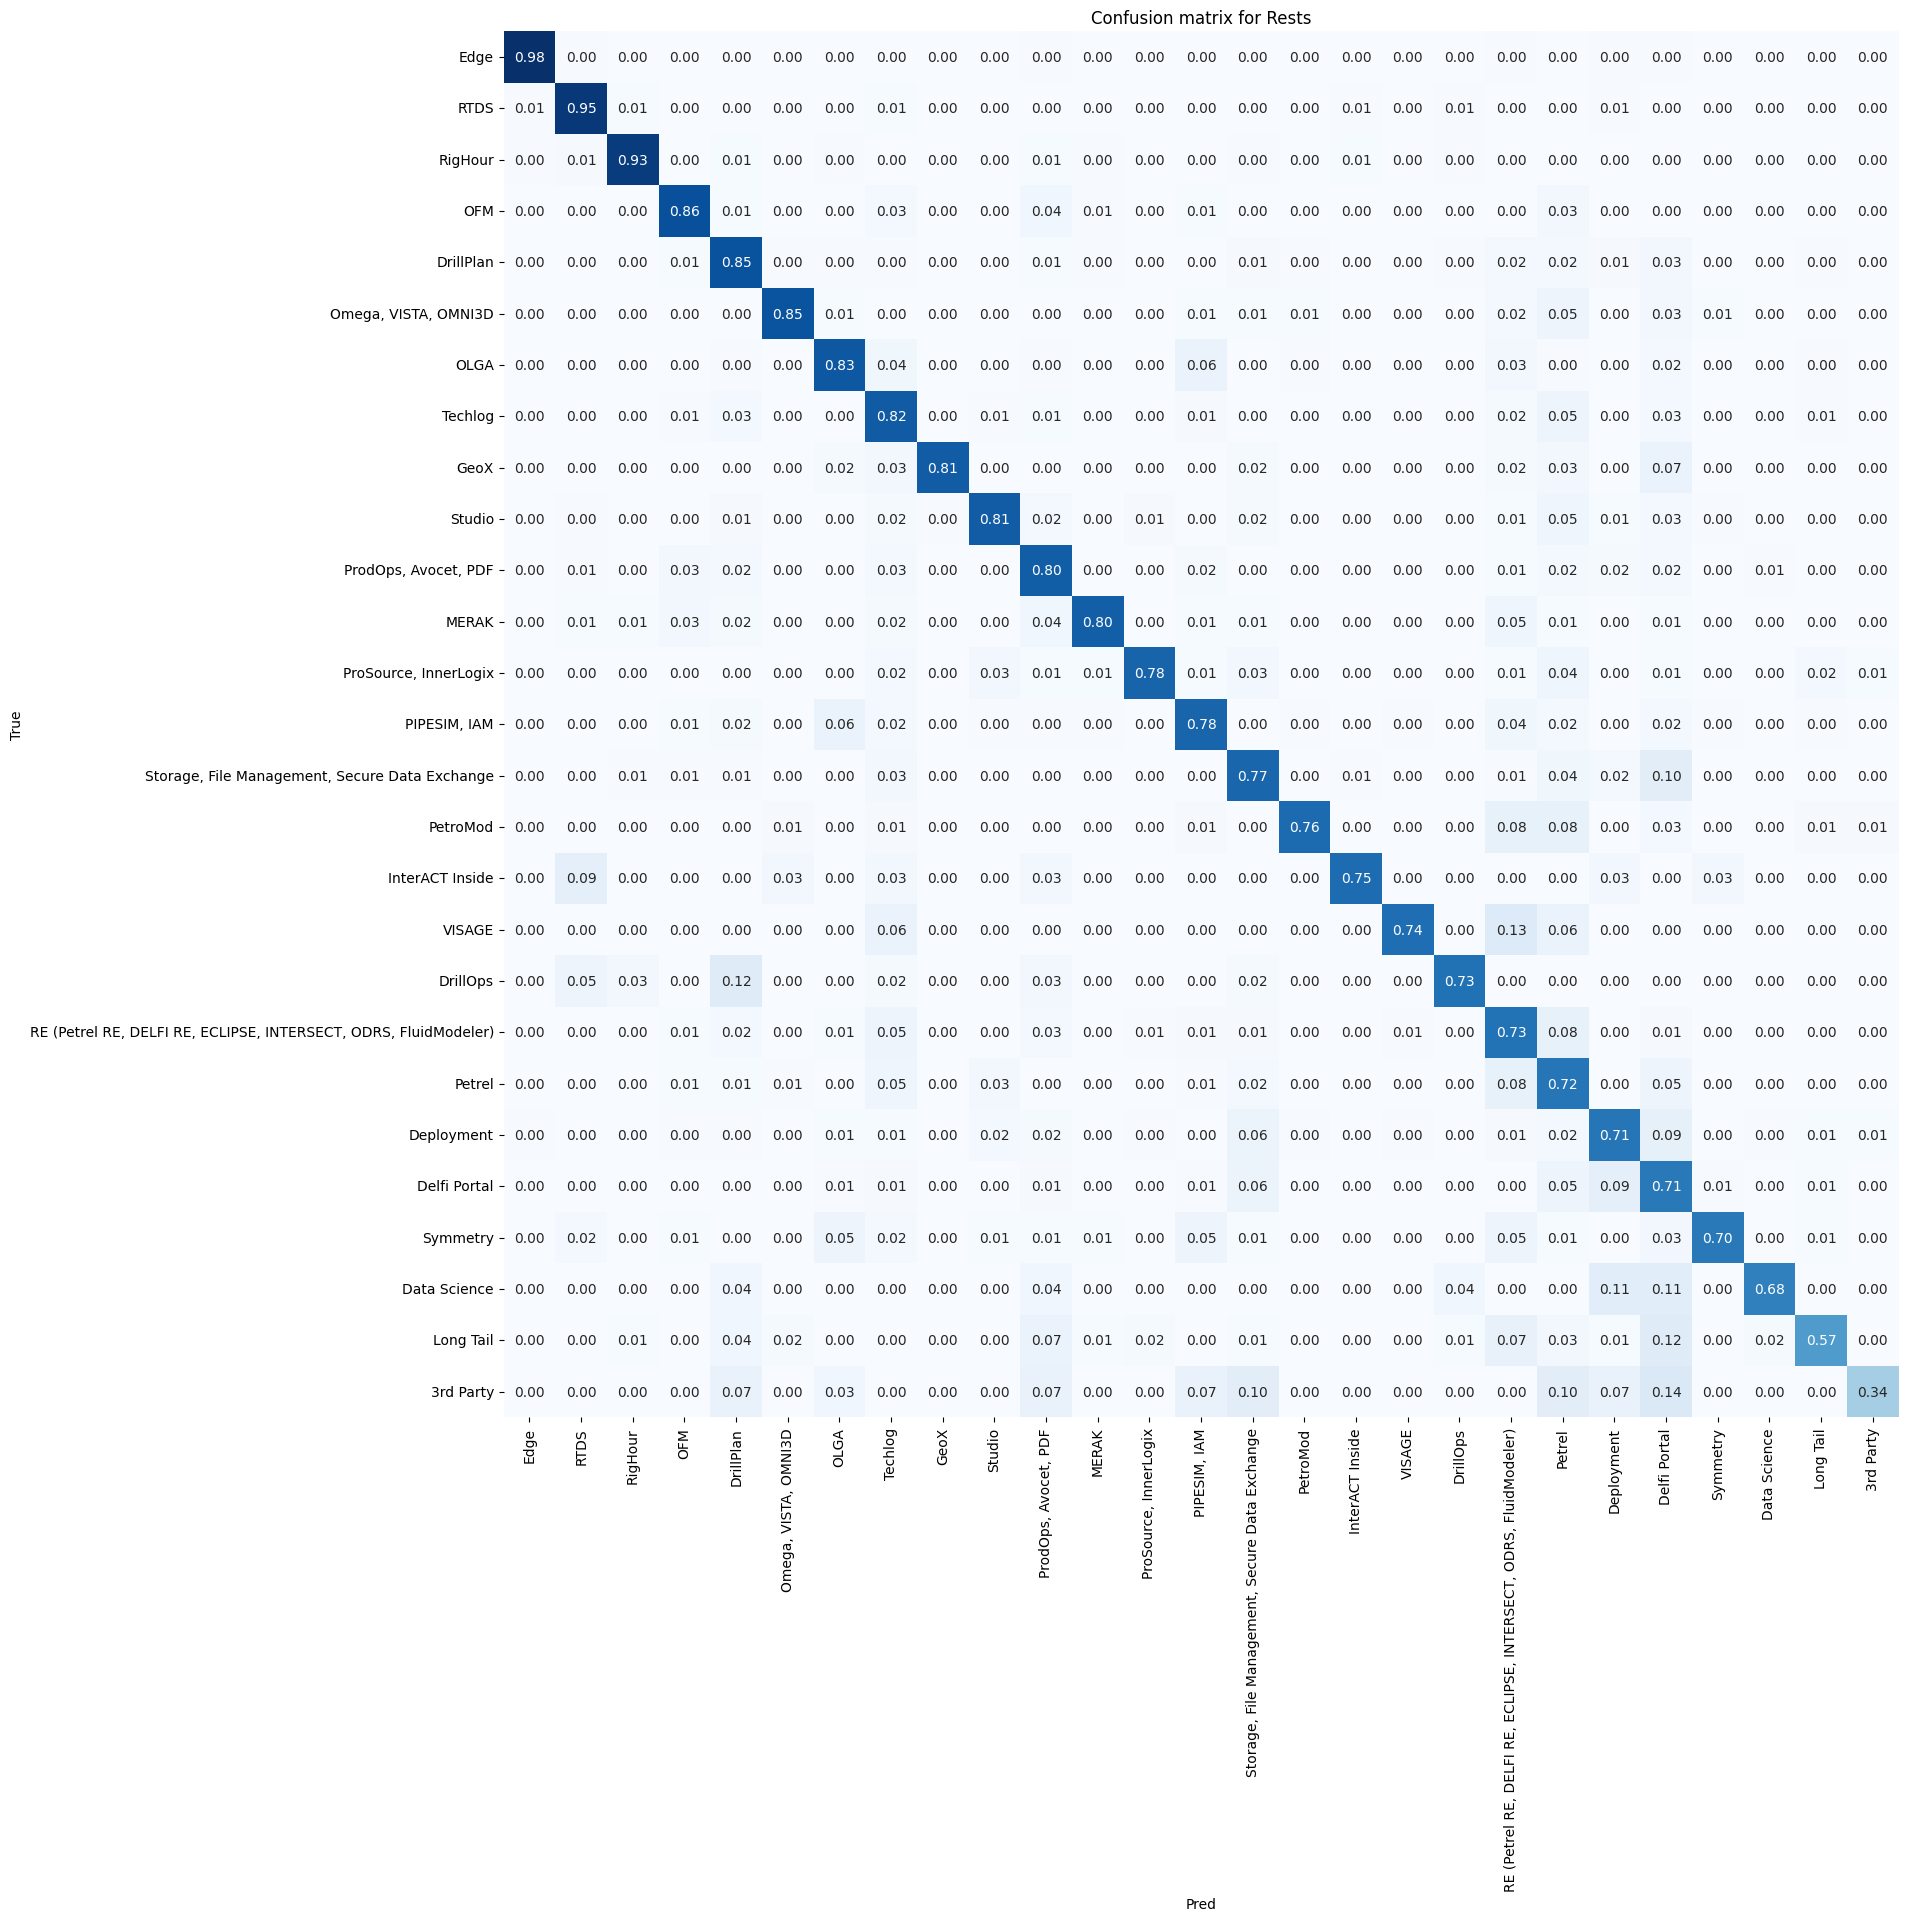

Accuracy of top 1 prediction is 0.798.
Accuracy of top 3 prediction is 0.908.
Accuracy of top 5 prediction is 0.940.


In [45]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('sgc_classifier', best_model_sgc),
    ('svc_linear', best_model_svc_linear)
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))